# Audio Data Preparation

# Mount Google Drive to access zip file with data

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzip data into the *splits* directory

In [2]:
# create directory for data
!mkdir data

# unzip files from zip folder
!unzip "/content/drive/MyDrive/Projekt badawczy - terminy medyczne/001_004.zip" -d "data/"

Archive:  /content/drive/MyDrive/Projekt badawczy - terminy medyczne/001_004.zip
   creating: data/001_004/
  inflating: data/001_004/001_004_online.csv  
  inflating: data/001_004/004_00005_20230711T124716.wav  
  inflating: data/001_004/004_00017_20230711T124847.wav  


# Normalisation

The goal of normalisation is to adjust the volume of audio files to a standard set level; if this isn’t done, the volume can differ greatly from word to word, and the files can end up unable to be processed clearly.

<ipython-input-47-280513feeb73>:40: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(raw_sound), ref=np.max), sr=sr, x_axis='time', y_axis='log')
<ipython-input-47-280513feeb73>:50: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(normalized_sound), ref=np.max), sr=sr, x_axis='time', y_axis='log')


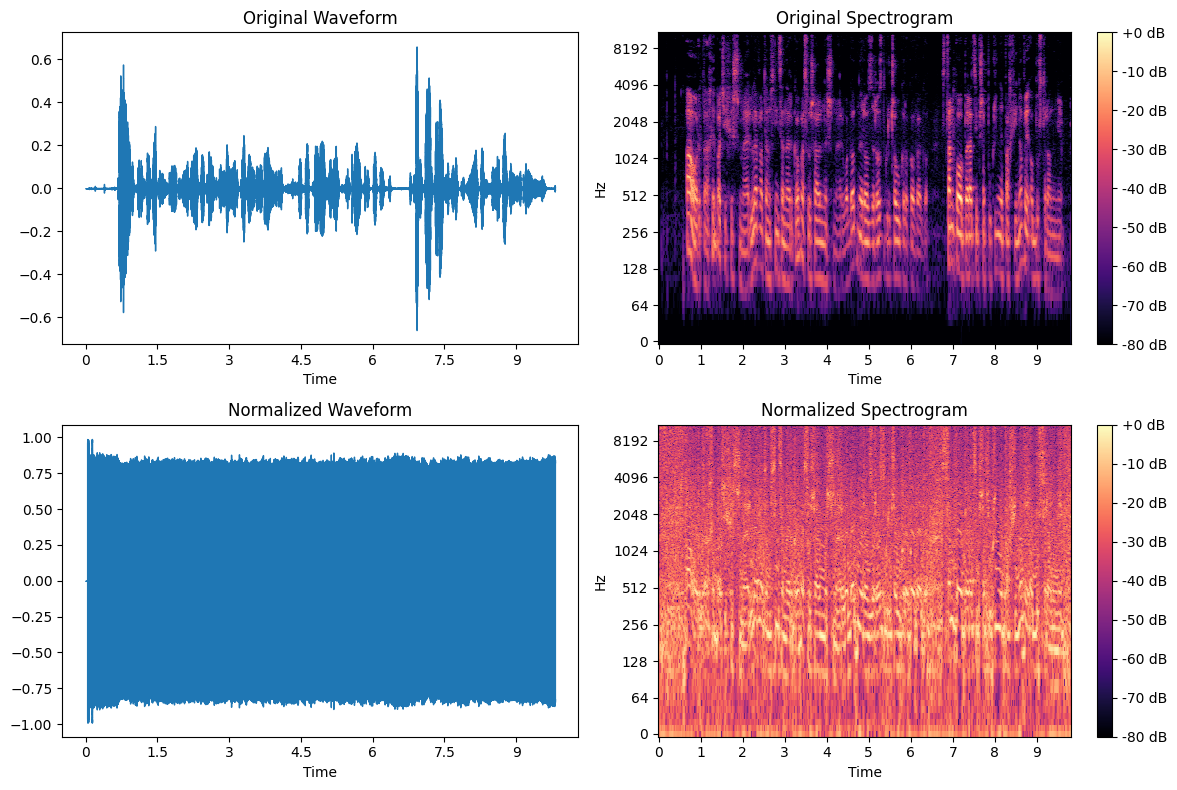

In [47]:
import pathlib
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment, effects

# Define the path to the directory containing audio files
data_path = pathlib.Path('./data/001_004/')

# List the audio files in the directory
files = list(data_path.glob('*'))
file_to_normalize = files[0]

# Load the raw audio file
raw_sound, sr = librosa.load(file_to_normalize)

# Convert the raw audio to AudioSegment object
audio_segment = AudioSegment(raw_sound.tobytes(), frame_rate=sr, sample_width=raw_sound.dtype.itemsize, channels=1)

# Normalize the audio using AudioSegment
normalized_audio_segment = effects.normalize(audio_segment)

# Export the normalized audio to a new file
filename = str(file_to_normalize).split('/')[-1].split('.')[0]
normalized_temp_file = filename + '_Normalised.wav'
normalized_audio_segment.export(normalized_temp_file, format="wav")

# Load the normalized audio using librosa
normalized_sound, _ = librosa.load(normalized_temp_file, sr=sr)

# Plot waveform and spectrogram for original audio
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
librosa.display.waveshow(raw_sound, sr=sr)
plt.title('Original Waveform')

plt.subplot(2, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(raw_sound), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Plot waveform and spectrogram for normalized audio
plt.subplot(2, 2, 3)
librosa.display.waveshow(normalized_sound, sr=sr)
plt.title('Normalized Waveform')

plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(normalized_sound), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized Spectrogram')

plt.tight_layout()
plt.show()


# Resampling audio data

Based on the [Librosa documentation](https://librosa.org/blog/2019/07/17/resample-on-load/) - the sampling rate of the audio file is set during the loading of an audio file. The default resampling value is 22050.

You can always bypass resample-on-load by specifying *sr=None* (then the audio file will be loaded with its original sampling rate):

```python
sr = 30000  # set sampling rate
y, sr = librosa.load(filename, sr=sr)
```

In [34]:
import librosa
import pathlib
import os

data_path = pathlib.Path('./data/001_004/')
# List the first 11 files in the directory
files = list(data_path.glob('*'))
sr = 30000
wav, sr = librosa.load(files[0], sr=sr)  # use your own sampling rate
# wav, sr = librosa.load(files[0], sr=None)  # use original sampling rate from audio file
print("wav:", wav)
print("sr:", sr)

wav: [0.         0.         0.         ... 0.00236872 0.00329869 0.0029899 ]
sr: 30000



# Audio Data Augmentation

Code comes from: [audio-data-augmentation-visualization-librosa-notebook](https://gist.github.com/keyurparalkar/5a49f696ed36ddce6526ab50e29e04ce).


## Import libraries

In [11]:
from fastai import *
from fastai.vision import *
import pathlib
import os
from scipy import signal
from scipy.io import wavfile
from fastprogress import progress_bar
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

## Load sample data

In [23]:
data_path = pathlib.Path('./data/001_004/')
# List the first 11 files in the directory
files = list(data_path.glob('*'))
print(files)

[PosixPath('data/001_004/004_00005_20230711T124716.wav'), PosixPath('data/001_004/004_00017_20230711T124847.wav'), PosixPath('data/001_004/001_004_online.csv')]


## Original

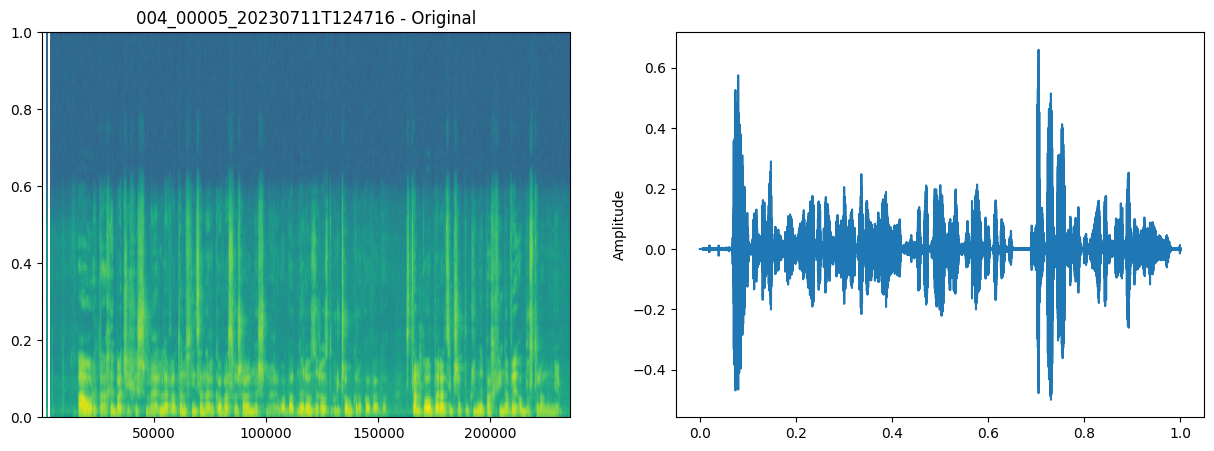

In [16]:
def plot_spec(data:np.array,sr:int,title:str, fpath:str, save_to_file=False) -> None:
    filename = str(fpath).split('/')[-1].split('.')[0]

    # plot graphs
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].title.set_text(f'{filename} - {title}')
    ax[0].specgram(data,Fs=2)
    # fig.savefig('temp1.png',bbox_inches="tight",pad_inches=0)
    ax[1].set_ylabel('Amplitude')
    ax[1].plot(np.linspace(0,1,len(data)), data)

    # save sound to a new file
    if save_to_file:
        sf.write(filename + '_' + save_to_file + '.wav', data, sr)


file_path = files[0]
wav, sr = librosa.load(file_path, sr=None)
sound_name = 'Original'
plot_spec(wav, sr, sound_name, file_path, save_to_file = sound_name)
ipd.Audio(data=wav,rate=sr)

## Noise addition

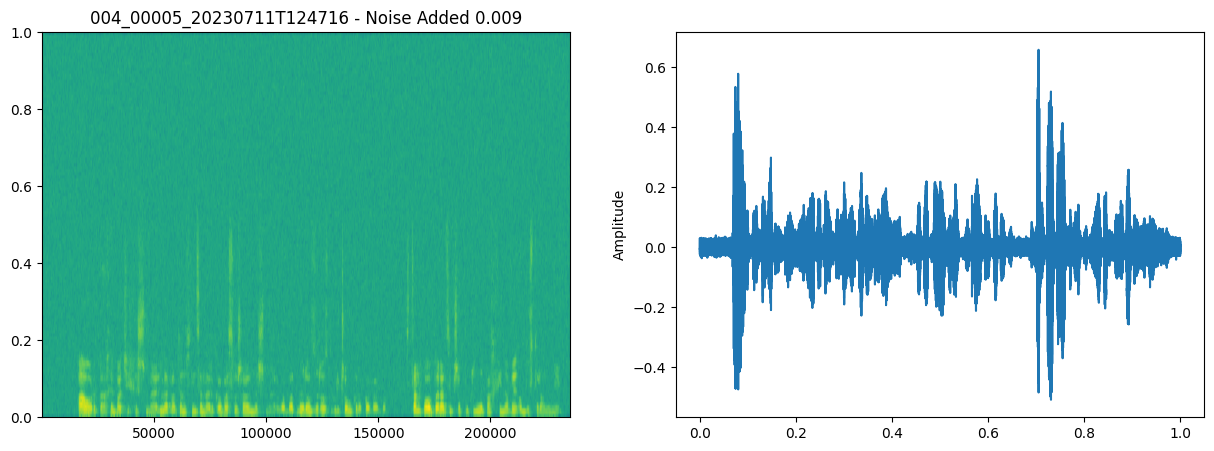

In [18]:
'''
Noise addition using normal distribution with mean = 0 and std =1

Permissible noise factor value = x > 0.004
'''
wav_n = wav + 0.009*np.random.normal(0,1,len(wav))
sound_name = 'WhiteNoise'
plot_spec(wav_n,sr,'Noise Added 0.009', file_path, save_to_file = sound_name)
ipd.Audio(data=wav_n,rate=sr)

## Shifting the sound wave

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


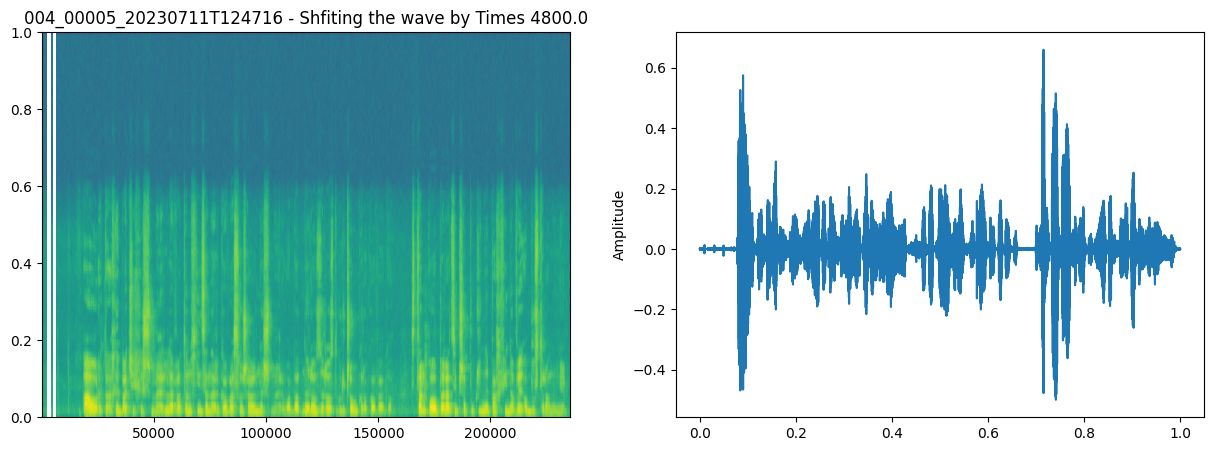

In [19]:
'''
Permissible factor values = sr/10
'''

wav_roll = np.roll(wav,int(sr/10))
ipd.Audio(wav_roll,rate=sr)
sound_name = 'TimeShift'
plot_spec(data=wav_roll,sr=sr,title=f'Shfiting the wave by Times {sr/10}',fpath=file_path, save_to_file = sound_name)


## Time-stretching

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


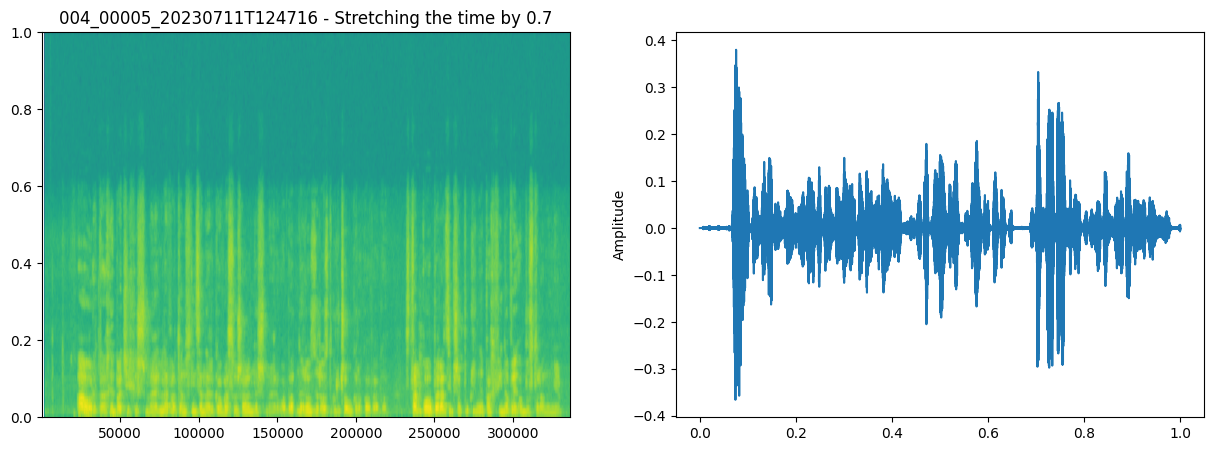

In [20]:
'''
Permissible factor values = 0 < x < 1.0
'''

factor = 0.7
wav_time_stch = librosa.effects.time_stretch(y=wav,rate=factor)
sound_name = 'TimeStrech'
plot_spec(data=wav_time_stch,sr=sr,title=f'Stretching the time by {factor}',fpath=file_path, save_to_file = sound_name)
ipd.Audio(wav_time_stch,rate=sr)



## Pitch shifting

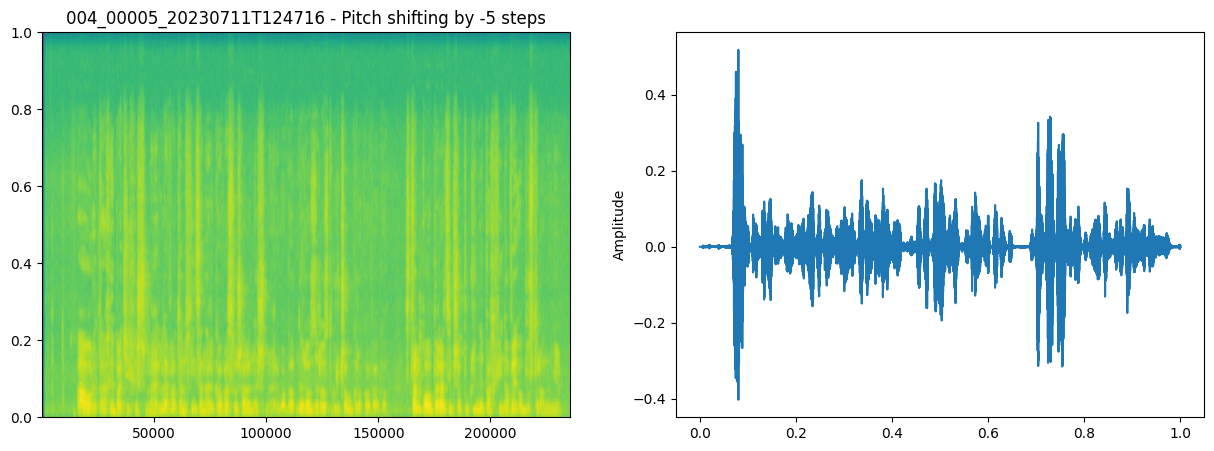

In [21]:
'''
Permissible factor values = -5 <= x <= 5
'''
wav_pitch_sf = librosa.effects.pitch_shift(y=wav,sr=sr,n_steps=5)
sound_name = 'PitchShift'
plot_spec(data=wav_pitch_sf,sr=sr,title=f'Pitch shifting by {-5} steps',fpath=file_path, save_to_file = sound_name)
ipd.Audio(wav_pitch_sf,rate=sr)

-----------------------------------